# Maze Solver 2.0

In [1]:
maze = [
    [".", ".", ".", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", ".", "#", "#", "#", "#", "#", ".", ".", ".", "."],
    [".", "#", "#", ".", ".", ".", ".", ".", "#", ".", "."],
    [".", ".", "#", ".", ".", ".", ".", ".", "#", ".", "."],
    ["#", ".", "#", ".", ".", ".", ".", ".", "#", ".", "#"],
    [".", ".", "#", ".", ".", ".", ".", ".", ".", ".", "."],
    [".", "#", "#", "#", "#", ".", ".", "#", ".", "#", "."],
    [".", "#", ".", ".", "F", "#", ".", "#", "#", "#", "."],
    [".", "#", ".", "#", "#", "#", "#", "#", ".", ".", "."],
    [".", "#", ".", "#", ".", ".", ".", ".", ".", "#", "."],
    [".", "#", ".", "#", "#", "#", "#", "#", ".", "#", "."],
    [".", "#", ".", ".", ".", "#", ".", ".", ".", ".", "."],
    [".", "#", "#", "#", ".", "#", ".", "#", "#", ".", "."],
    ["S", "#", ".", ".", ".", ".", ".", ".", ".", "#", "."]
]

maze_types = ["random_maze", "room_maze", "cellular_automaton", "primitive", "row_by_row"]
# maze_types = ["room_maze", "primitive", "row_by_row"]

import collections
import time
import random
import numpy
from termcolor import colored
import turtle
import math
import numpy as np
import os.path
import pandas as pd
import sys

class Pen(turtle.Turtle):
    def __init__(self, color, size):
        turtle.Turtle.__init__(self)
        self.shape("square")
        self.shapesize(size[0], size[1])
        self.color(color)
        self.penup()
        
class Player(turtle.Turtle):
    def __init__(self, color, size):
        turtle.Turtle.__init__(self)
        self.shape("circle")
        self.shapesize(size[0], size[1])
        self.color(color)
        self.penup()
        self.steps = 0
        self.finish = False
        
class Dot(turtle.Turtle):
    def __init__(self, x, y, color, size):
        turtle.Turtle.__init__(self)
        self.shape("circle")
        self.shapesize(size[0], size[1])
        self.color(color)
        self.penup()
        self.steps = 1
        self.goto(x, y)
    
    def destroy(self):
        self.hideturtle()
        
class Finish(turtle.Turtle):
    def __init__(self, x, y, color, size):
        turtle.Turtle.__init__(self)
        self.shape("circle")
        self.shapesize(size[0], size[1])
        self.color(color)
        self.penup()
        self.goto(x, y)
        
class Queue:
    def __init__(self):
        self.elements = collections.deque()
    
    def empty(self):
        return len(self.elements) == 0 #True or False
    
    def put(self, x):
        self.elements.append(x)
    
    def get(self):
        return self.elements.popleft()

class Graph:
    def __init__(self, maze):
        self.height = len(maze)
        self.width = len(maze[0])
        self.stats = {}
        self.start = ()
        self.path = {}
        self.success = []
        self.time = "Null"
        self.playerPathLength = "Null"
        self.score = "Null"
        for y in range(self.height):
            for x in range(self.width):
                self.stats[x, y] = maze[y][x]
                if maze[y][x] == "S":
                    self.start = (x, y)
        
    def print_graph(self, player_x = "not", player_y = "not"):
        player_pos = ()
        for y in range(self.height):
            row = []
            for x in range(self.width):
                if player_x is not "not" and player_x == x and player_y == y:
                    if x + 1 == self.width:
                        row.append(" |P|")
                        
                    else:
                        row.append("|P")
                else:
                    if x + 1 == self.width:
                        row.append("|" + self.stats[x, y] + "|")
                    else:
                        row.append("|" + self.stats[x, y])
            print(*row, sep='')
        print()
        
    def in_bounds(self, id):
        (x, y) = id
        return 0 <= x < self.width and 0 <= y < self.height
    
    def passable(self, id):
        return self.stats[id] is not "#"
    
    def unknown(self, known, pos):
        k = []
        for i in range(len(pos)):
            if pos[i] not in known:
                k.append(pos[i])
        return k
    
    def neighbors(self, id):
        (x, y) = id
        results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        if (x + y) % 2 == 0: 
            results.reverse()
        results = list(filter(self.in_bounds, results))
        results = list(filter(self.passable, results))
        return results
    
    def true_neighbors(self, id):
        (x, y) = id
        results = [(x+1, y), (x, y-1), (x-1, y), (x, y+1)]
        if (x + y) % 2 == 0: 
            results.reverse()
        results = list(filter(self.in_bounds, results))
        return results
    
    def diagonals(self, id):
        (x, y) = id
        results = [(x+1, y+1), (x-1, y-1), (x-1, y+1), (x+1, y-1)]
        if (x + y) % 2 == 0: 
            results.reverse()
            
        results = list(filter(self.in_bounds, results))
        results = list(filter(self.passable, results))
        
        return results
    
    def print_path(self, path):
        if path != None:
            for y in range(self.height):
                row = []
                for x in range(self.width):
                    if [x, y] in path:
                        if x + 1 == self.width:
                            row.append("|P|")
                        else:
                            row.append("|P")
                    else:
                        if x + 1 == self.width:
                            row.append("|" + self.stats[x, y] + "|")
                        else:
                            row.append("|" + self.stats[x, y])

                print(*row, sep='')
        print()
    
    
    def search_1(self, return_len = False):
        frontier = Queue()
        frontier.put(self.start)

        finish = ()
        self.path[self.start] = [[self.start]]

        while not frontier.empty():
            current = frontier.get()

            for next in self.neighbors(current):
                if next not in self.path:
                    self.path[next] = self.path[current] + [[current[0], current[1]]]
                    frontier.put(next)
                if self.stats[next] == "F":
                    self.success = self.path[next]
                    finish = next
                    break
        
        if finish != ():
            if not return_len:
                return self.path[finish][2:]
            else:
                print(len(self.path[finish][2:]))
                return len(self.path[finish][2:])
        else:
            print("Impossible maze")
            self.print_graph()
            
    def random_maze(self, w, h):
        l = ['.'] * w
        maze = [l] * h
        
        self.height = h
        self.width = w
        self.stats = {}
        for y in range(self.height):
            for x in range(self.width):
                self.stats[x, y] = maze[y][x]
        self.start = (random.randint(0, w), random.randint(0, h))
        self.stats[self.start] = "S"
        self.path = {}
        
        frontier = Queue()
        frontier.put(self.start)
        mapped = [(self.start)]
        current = self.start
        stack = [(self.start)]
    
        while len(mapped) < w*h:
            for next in self.unknown(mapped, list(self.diagonals(current))):
                mapped.append(next)
                if random.random() < 0.5:
                    self.stats[next] = "#"
                else:
                    self.stats[next] = "."
                    stack.append(next)
                    
            possible = list(self.neighbors(current))
            possible = self.unknown(mapped, possible)
            
            if possible != []:
                current = random.choice(possible)
                if random.random() < 0.1:
                    self.stats[next] = "#"
                    stack.append(next)
                else:
                    self.stats[current] = "."
                    mapped.append(current)
                    stack.append(next)
            else:
                current = stack.pop(0)
            
        self.stats[current] = "F"
        self.stats[(current[0], current[1] - 1)] = "."
        self.stats[self.start] = "S"
        
    def divide_maze(self, width, height):
        if width[1] - width[0] >= 3 and height[1] - height[0] >= 3:
            wall_x = random.randint(width[0] + 1, width[1] - 2)
            wall_y = random.randint(height[0] + 1, height[1] - 2)
            for i in range(height[0], height[1] + 1):
                self.stats[wall_x, i] = "#"
            for i in range(width[0], width[1] + 1):
                self.stats[i, wall_y] = "#"

            self.stats[wall_x, random.randint(height[0], wall_y-1)] = "." 
            self.stats[wall_x, random.randint(wall_y+1, height[1])] = "." 
            self.stats[random.randint(width[0], wall_x-1), wall_y] = "." 
            self.stats[random.randint(wall_x+1, width[1]), wall_y] = "." 
            
            self.divide_maze((width[0], wall_x - 1), (height[0], wall_y - 1))
            self.divide_maze((wall_x + 1, width[1]), (height[0], wall_y - 1))
            self.divide_maze((width[0], wall_x - 1), (wall_y + 1, height[1]))
            self.divide_maze((wall_x + 1, width[1]), (wall_y + 1, height[1]))
            
        elif width[1] - width[0] >= 3 and height[1] - height[0] >= 2:
            wall_x = random.randint(width[0] + 1, width[1] - 2)
            for i in range(height[0], height[1] + 1):
                self.stats[wall_x, i] = "#"
            self.stats[wall_x, random.randint(height[0], height[1])] = "." 
            
            self.divide_maze((width[0], wall_x - 1), (height[0], height[1]))
            self.divide_maze((wall_x + 1, width[1]), (height[0], height[1]))
            
            
        elif width[1] - width[0] >=2 and height[1] - height[0] >= 3:
            wall_y = random.randint(height[0] + 1, height[1] - 2)
            for i in range(width[0], width[1] + 1):
                self.stats[i, wall_y] = "#"
            self.stats[random.randint(width[0], width[1]), wall_y] = "." 
            
            self.divide_maze((width[0], width[1]), (wall_y + 1, height[1]))
            self.divide_maze((width[0], width[1]), (wall_y + 1, height[1]))

            
        
    def room_maze(self, w = 35, h = 35):
        l = ['.'] * w
        maze = [l] * h
        
        self.height = h
        self.width = w
        self.stats = {}
        for y in range(self.height):
            for x in range(self.width):
                self.stats[x, y] = maze[y][x]
                
        if random.random() >= 0.5:
            if random.random() >= 0.5:
                self.start = (0, random.randint(1, h - 2))
            else:
                self.start = (w - 1, random.randint(1, h - 2))
        else:
            if random.random() >= 0.5:
                self.start = (random.randint(1, w - 2), 0)
            else:
                self.start = (random.randint(1, w - 2), h - 1)
                
        self.stats[self.start] = "S"
        self.path = {}
        
        frontier = Queue()
        frontier.put(self.start)
        mapped = [(self.start)]
        current = self.start
        stack = [(self.start)]
        
        self.divide_maze([0, w - 1], [0, h - 1])
        ok = False
        while not ok:
            (x, y) = (random.randint(0, w - 1), random.randint(0, h - 1))
            if self.stats[x, y] == ".":
                self.stats[x, y] = "F"
                self.stats[self.start] = "S"
                ok = True
                
    def cellular_automaton(self, w = 35, h = 35):
        self.height = h
        self.width = w
        self.stats = {}
        for y in range(self.height):
            for x in range(self.width):
                if random.random() > 0.4:
                    self.stats[x, y] = "."
                else:
                    self.stats[x, y] = "#"
        for i in range(5):
            self.print_graph()
            next_gen_stats = {}
            #rules
            for y in range(self.height):
                for x in range(self.width):
                    neighbors = self.neighbors((x, y)) + self.diagonals((x, y))
                    if self.stats[x, y] == "#":
                        if len(neighbors) == 3: # 3
                            next_gen_stats[x, y] = "."
                        else:
                            next_gen_stats[x, y] = "#"
                    else:
                        if len(neighbors) >= 1 and len(neighbors) <= 5: # 1-5
                            next_gen_stats[x, y] = "."
                        else:
                            next_gen_stats[x, y] = "#"
                        
            self.stats = {k: v for k, v in next_gen_stats.items()}     
#             self.print_graph()
            
        self.start = (random.randint(0, w - 1), random.randint(0, h - 1))
        self.stats[self.start] = "S"
        self.stats[random.randint(0, w - 1), random.randint(0, h - 1)] = "F"
        
    def primitive(self, w = 35, h = 35):
        self.height = h
        self.width = w
        self.stats = {}
        for y in range(self.height):
            for x in range(self.width):
                self.stats[x, y] = "#"    
        
        self.start = (random.randint(0, w - 1), random.randint(0, h - 1))
        self.stats[self.start] = "."
        
        visited = [self.start]
        came_from = {}
        for next in self.true_neighbors(self.start):
            came_from[next] = self.start
        wall_list = self.true_neighbors(self.start)
        
        def check(id):
            return id not in visited
        s = 0
        while wall_list:
            s += 1
#             print(str(wall_list) + " wall list")
#             print(str(visited) + " visited")
            current = random.choice(wall_list)
            visited.append(current)
            wall_list.remove(current)
#             print(str(current) + " current")
            connects_to = tuple(numpy.subtract(current, tuple(numpy.subtract(came_from[current], current))))
#             print(str(connects_to) + " connects to")
            if connects_to not in visited:
                self.stats[current] = "."
                self.stats[connects_to] = "."
                visited.append(connects_to)
                wall_list = wall_list + list(filter(check, self.true_neighbors(connects_to)))
                for next in list(filter(check, self.true_neighbors(connects_to))):
                    came_from[next] = connects_to
            finish = connects_to
#             if s % 1 == 0 and s < 500:
#             self.print_graph()
        self.stats[self.start] = "S"
        self.stats[finish] = "F"
                
    def row_by_row(self, w = 35, h = 35):
        self.height = h
        self.width = w
        self.stats = {}
        passages = []
        for y in range(self.height):
            for x in range(self.width):
                if y == 0:
                    if random.random() > 0.5:
                        self.stats[x, y] = "."
                        passages.append((x, y))
                    else:
                        self.stats[x, y] = "#"
                else:
                    if (x, y) in passages:
                        self.stats[x, y] = "."
                    else:
                        self.stats[x, y] = "#"
                    
#             print(passages)
            new_passages = []
            for x in range(self.width):
                if (x, y) not in passages:
                    if random.random() > 0.5:
                        new_passages.append((x, y + 1))
#             print(new_passages)
            group = []
            for i in range(self.width):
                if self.stats[i, y] == ".":
                    group.append(passages[0])
                    passages.pop(0)
                    if i + 1 == self.width:
                        passages.append(group)
                else:
                    if len(group) >= 1:
                        passages.append(group)
                    group = []
                    
#             print(str(passages) + " passages")
            for i in range(len(passages)):
                num_of_down = random.randint(1, len(passages[i]))
                for d in range(num_of_down):
                    down = random.choice(passages[i])
                    new_passages.append((down[0], down[1] + 1))
                    passages[i].remove(down)
#             print(new_passages)
            new_passages.sort()
#             print(new_passages)
#             print("ok")
            passages = new_passages
#             print(passages)
        self.start = ()
        while self.start == ():
            self.start = (random.randint(0, w - 1), random.randint(0, h - 1))
            if self.stats[self.start] != ".":
                self.start = ()
        self.stats[self.start] = "S"
        self.stats[random.randint(0, w - 1), random.randint(0, h - 1)] = "F"
            
            
            
    def optimize_maze(self):
        frontier = Queue()
        frontier.put(self.start)

        finish = ()
        player_pos = ()
        came_from = {}
        path = {}
        came_from[self.start] = None
        path[self.start] = [[self.start]]

        while not frontier.empty():
            current = frontier.get()

            for next in self.neighbors(current):
                if next not in came_from:
                    path[next] = path[current] + [[current[0], current[1]]]
                    frontier.put(next)
                    came_from[next] = current
                    
        max_key = ""
        max_len = 0
        for key in path:
            cur_len = len(path[key])
            if cur_len > max_len:
                max_key = key
                
#         self.path = path
#         self.success = self.path[max_key]
               
        for pos, stat in self.stats.items():
            if stat == "F":
                x = pos

        self.stats[x] = "."
#         value = path[max_key][-1]
        self.stats[max_key[0], max_key[1]] = "F"

        

        
    
        

def print_to_file(filename, num = 1, graph_type = "make_room_maze", size = (35, 35), minimum = 0):
    file = open(filename,"w+")
        
    if num > 0:
        file.write("Daily Mazes:  \n\n")
        graphs = []
        path_length = {}
        while len(graphs) < num:
            i = len(graphs) + 1
            globals()["maze_" + str(i)] = Graph(maze)
            getattr(globals()["maze_" + str(i)], graph_type)(size[0], size[1])
            globals()["maze_" + str(i)].optimize_maze()
            x = globals()["maze_" + str(i)].search_1(True)
            if x >= minimum:
                print(str(x) + " succsesful")
                globals()["maze_" + str(i)].print_graph()
                graphs.append(globals()["maze_" + str(i)])
                path_length[i] = x
            
        for i in range(num):
            print(str(len(path_length)) + " path")
            print(path_length)
            print(min(path_length))
            
            
            file.write("Graph number " + str(i + 1) + "\n\n")
            print(min(path_length, key=path_length.get))
            maze_to_print = graphs[min(path_length, key=path_length.get) - 1]
            path_length.pop(min(path_length, key=path_length.get))
                
            w = size[0]
            h = size[1]
            for y in range(0, h):
                row = []
                for x in range(0, w):
                    if x + 1 == w:
                        row.append("|" + maze_to_print.stats[x, y] + "|")
                    else:
                        row.append("|" + maze_to_print.stats[x, y])
                    
                row = "".join(map(str, row))
                file.write(str(row) + "\n")  
            file.write("\n\n")
            
            
def print_stats_to_file(filename, mazeType, graph = False, num = False, size = (20, 20), played = False, clear = False):
    if clear:
        f = open(filename, "w+")
        f.write("type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength\n")
    if graph != False:
        size = (graph.width, graph.height)
        numWalls = 0
        numPassages = 0
        for y in range(graph.height):
            for x in range(graph.width):
                if graph.stats[x, y] == ".":
                    numPassages += 1
                elif graph.stats[x, y] == "#":
                    numWalls += 1
        pathLength = len(graph.success)
        distFromStartToFinish = round(math.sqrt((graph.start[0] - graph.success[-1][0])** 2 + (graph.start[1] - graph.success[-1][1])** 2))
        time = graph.time
        playerPathLength = graph.playerPathLength
        score = graph.score
        
        if not os.path.isfile(filename):
            f = open(filename, "a+")
            f.write("type,size,area,path length,dist from start to finish,walls,passages,time,score,player path length\n")
            f.write(mazeType + "," + str(size[0]) + "by" + str(size[1]) + "," + str(size[0] * size[1]) + "," + str(pathLength) + "," + str(distFromStartToFinish) + "," + str(numWalls) + "," + str(numPassages) + "," + str(time) + "," + str(score) + "," + str(playerPathLength) + "\n")
        else:
            f = open(filename, "a")
            f.write(mazeType + "," + str(size[0]) + "by" + str(size[1]) + "," + str(size[0] * size[1]) + "," + str(pathLength) + "," + str(distFromStartToFinish) + "," + str(numWalls) + "," + str(numPassages) + "," + str(time) + "," + str(score) + "," + str(playerPathLength) + "\n")
        
    elif num != False:
        for i in range(num):
            graph = Graph(maze)
            getattr(graph, mazeType)(size[0], size[1])
            graph.optimize_maze()
            
            size = (graph.width, graph.height)
            numWalls = 0
            numPassages = 0
            for y in range(size[1]):
                for x in range(size[0]):
                    if graph.stats[x, y] == ".":
                        numPassages += 1
                    elif graph.stats[x, y] == "#":
                        numWalls += 1
            pathLength = len(graph.success)
            distFromStartToFinish = round(math.sqrt((graph.start[0] - graph.success[-1][0])** 2 + (graph.start[1] - graph.success[-1][1])** 2))
            time = graph.time
            playerPathLength = graph.playerPathLength
            score = graph.score
    
            if not os.path.isfile(filename):
                f = open(filename, "a+")
                f.write("type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength\n")
                f.write(mazeType + "," + str(size[0]) + "by" + str(size[1]) + "," + str(size[0] * size[1]) + "," + str(pathLength) + "," + str(distFromStartToFinish) + "," + str(numWalls) + "," + str(numPassages) + "," + str(time) + "," + str(score) + "," + str(playerPathLength) + "\n")
            else:
                f = open(filename, "a")
                f.write(mazeType + "," + str(size[0]) + "by" + str(size[1]) + "," + str(size[0] * size[1]) + "," + str(pathLength) + "," + str(distFromStartToFinish) + "," + str(numWalls) + "," + str(numPassages) + "," + str(time) + "," + str(score) + "," + str(playerPathLength) + "\n")
            
def analize(mazeType, title = False, by = False):
    df = pd.read_csv("Graph Stats")
    df.filter(like=mazeType)
    isType =  df['type'] == mazeType
    df = df[isType]
    if by and title:
        df.plot(x=by, title=title)
    elif by:
        df.plot(x=by, title=mazeType)
    elif title:
        df.plot(title=title)
    else:
        df.plot()
            
            

        
def FindStats():
    for ind in range(len(maze_types)):
        for xSize in range(5, 50, 5):
            for ySize in range(5, 50, 5):
                print_stats_to_file("Graph Stats1", maze_types[ind], num = 1, size = (xSize + ind, ySize - ind))
                print(ind)
                
# FindStats()
                
# print_stats_to_file("Graph Stats", "cellular_automaton", num = 5, size = (40, 40), clear = True)
# print_stats_to_file("Graph Stats1", "random_maze", num = 2, size = (40, 40))

# analize("primitive")

g1 = Graph(maze)
g1.primitive(50, 50)
g1.optimize_maze()
g1.print_graph()
# game1 = MazeLevel(g1)
# game1.playLevel()

# Tell It What To Do

# print_to_file("ex. graph2", 20, "primitive", (50, 76), 140)

# g1 = Graph(maze)
# path = g1.search_1(True)
# g1.print_path(path)
# g1.primitive(20, 20)
# g1.print_graph()
# g1.optimize_maze()
# g1.print_graph()
# path = g1.search_1()
# g1.print_path(path)

# g2 = Graph(maze)
# g2.cellular_automaton(35, 35)
# g2.optimize_maze()
# g2.print_graph()
# path = g2.search_1()
# g2.print_path(path)
# print_to_file("ex. graph1", 30, "make_room_maze", (50, 75))

# g3 = Graph(maze)
# g3.make_random_maze(35, 35)
# g3.optimize_maze()
# path = g3.search_1()
# g3.print_path(path)


|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|
|.|.|.|#|.|.|.|.|.|.|.|.|.|.|.|.|.|#|.|#|.|#|.|.|.|.|.|.|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|.|.|#|.|#|.|.|
|#|#|.|#|#|#|#|#|.|#|#|#|#|#|.|#|#|#|.|#|.|#|.|#|#|#|#|#|#|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|#|#|.|#|.|#|
|.|#|.|#|.|.|.|#|.|#|.|.|.|#|.|.|.|#|.|#|.|#|.|#|.|.|.|#|.|.|.|#|.|#|.|.|.|.|.|#|.|#|.|.|.|#|.|#|.|.|
|.|#|.|#|.|#|#|#|.|#|.|#|#|#|#|#|#|#|.|#|.|#|.|#|#|#|.|#|#|#|.|#|.|#|.|#|#|#|#|#|.|#|#|#|.|#|.|#|.|#|
|.|.|.|#|.|#|.|#|.|#|.|.|.|#|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|#|.|.|.|#|.|#|.|#|.|#|.|#|.|#|.|.|.|.|.|.|
|#|#|.|#|.|#|.|#|.|#|#|#|.|#|#|#|#|#|.|#|#|#|#|#|#|#|#|#|#|#|.|#|#|#|.|#|.|#|.|#|.|#|.|#|.|#|#|#|#|#|
|.|.|.|.|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|.|.|.|.|#|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|.|
|#|#|.|#|#|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|.|#|#|#|.|#|.|#|.|#|#|#|#|#|#|#|.|#|#|#|#|#|#|#|.|#|.|#|.|#|
|.|#|.|.|.|#|.|.|.|.|.|#|.|.|.|#|.|.|.|.|.|.|.|#|.|#|.|#|.|#|.|.|.|.|.|#|.|.|.|.|.

In [3]:
data1_df = pd.read_csv("Graph Stats1")
display(data1_df)

df = pd.read_csv("Graph Stats1")
colors = {'primitive': 'blue', 'row_by_row': 'red', 'cellular_automaton': 'orange', 'random_maze': 'green', 'room_maze': 'purple', 'original': 'yellow'}
df.plot.scatter(x='area', y='pathLength', c=[colors[r] for r in df['type']])

,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength
0,room_maze,5by5,25,8,4,5,18,Null,Null,Null
1,room_maze,5by5,25,9,4,5,18,Null,Null,Null
2,room_maze,5by10,50,13,9,14,34,Null,Null,Null
3,room_maze,5by15,75,18,13,19,54,Null,Null,Null
4,room_maze,5by20,100,23,18,20,78,Null,Null,Null
5,room_maze,5by25,125,50,6,40,83,Null,Null,Null
6,room_maze,5by30,150,33,28,30,118,Null,Null,Null
7,room_maze,5by35,175,21,16,51,122,Null,Null,Null
8,room_maze,5by40,200,43,38,39,159,Null,Null,Null
9,room_maze,5by45,225,54,40,50,173,Null,Null,Null


In [12]:
graph = [
         [True,False,True],
         [True,False,True],
         [True,False,True]
         ]
print(graph)

[[True, False, True], [True, False, True], [True, False, True]]


In [4]:
import random
from graphics import *
windowSize = (600,600)



def drawMaze(graph,win,padding=10):
    print()
    mazeWidth = (windowSize[0] - 2*padding) # width of the maze after getting rid of the padding of the full window
    mazeHeight = (windowSize[1] - 2*padding)
    w = mazeWidth / len(graph[0])
    h = mazeHeight / len(graph)
    for y in range(len(graph)):
        for x in range(len(graph[y])):
            xPos = padding + (w*x)
            yPos = padding + (h*y)
            if graph[y][x]:
                drawRect(xPos,yPos,w,h,win)

def drawRect(x,y,w,h,win):
    r = Rectangle(Point(x,y), Point(x-w, y-h))
    r.setFill("black")
    return r

# def sunMove(sun):
#     for part in sun:
#         part.move(-2,0)
        
#     if sun[3].p1.getX() <= 0:
#         for part in sun: #for each loop - use for lists
#             part.move(windowSize[0] + 140, 0)
            
# def moonMove(sun):
#     sun.move(-2,0)
        
#     if sun.p1.getX() <= 0:
#         for part in sun: #for each loop - use for lists
#             part.move(windowSize[0] + 40, 0)
    
# def askForSuns():
#     ans = input("How many suns exist in your sky?")
#     if ans.isdigit():
#         return int(ans)
#     else:
#         print("Plase enter a number only.")
#         return askForSuns()
    
# def drawPumpkin(x,y,r,win):
#     c = Circle(Point(x, y), r)
#     c.setFill("orange")
#     tw = r/10 # 1/2 trunk width
#     r1 = Rectangle(Point(x-tw, y-r-(tw*2)), Point(x+tw, y-r))
#     r1.setFill("green")
#     r2 = Rectangle(Point(x-(tw/2), y-r-(tw*2)-5), Point(x+(tw/2), y-r-(tw*2)))
#     r2.setFill("brown")
#     c.draw(win)
#     r2.draw(win)
#     r1.draw(win)
#     return [c,r1,r2]

# def jumpScare(win):
#     c = Circle(Point(windowSize[0]/2, windowSize[1]/2), windowSize[0])
#     c.setFill("black")
    # c1 = Circle(Point(windowSize[0]-50, 50), 40)
    # c1.setFill("gray")
    # c2 = Circle(Point(50, 50), 40)
    # c2.setFill("gray")
    # background = Image(Point(300,300),"Pictures/JumpScare.png")
    # c.draw(win)
    # c1.draw(win)
    # c2.draw(win)
    # background.draw(win)
    # return [c1,c2]



def main():
    win = GraphWin("Maze - Graph Theory", windowSize[0], windowSize[1], False)
    # background = Image(Point(300,300),"Pictures/Background.png")
    # background.draw(win)
    # pumpkin = Image(Point(300,300),"Pictures/Background.png")
    
    # sky = []
    # pumpkins = []
    # numberOfSuns = askForSuns()
    # for i in range(numberOfSuns):
    #     sun = drawSun(random.randint(0, 600), random.randint(50, 100), random.randint(20, 40), random.randint(15, 20), win)
    #     sky.append(sun)
        
    win.getMouse()
    print("hello")
    drawMaze(graph,win)
    win.getMouse()
    # for x in range(500):
    #     update(30)




if __name__ == '__main__':
    main()

hello


NameError: name 'graph' is not defined

In [5]:
import arcade
import numpy as np

# Set constants for the screen size
SCREEN_WIDTH = 600
SCREEN_HEIGHT = 600

# maze = [
#     ["#", ".", ".", ".", ".", ".", ".", ".", ".", "#", "."],
#     [".", ".", "#", "#", "#", "#", "#", ".", ".", ".", "."],
#     [".", "#", "#", ".", ".", ".", ".", ".", "#", ".", "."],
#     [".", ".", "#", ".", ".", ".", ".", ".", "#", ".", "."],
#     ["#", ".", "#", ".", ".", ".", ".", ".", "#", ".", "#"],
#     [".", ".", "#", ".", ".", ".", ".", ".", ".", ".", "."],
#     [".", "#", "#", "#", "#", ".", ".", "#", ".", "#", "."],
#     [".", "#", ".", ".", "F", "#", ".", "#", "#", "#", "."],
#     [".", "#", ".", "#", "#", "#", "#", "#", ".", ".", "."],
#     [".", "#", ".", "#", ".", ".", ".", ".", ".", "#", "."],
#     [".", "#", ".", "#", "#", "#", "#", "#", ".", "#", "."],
#     [".", "#", ".", ".", ".", "#", ".", ".", ".", ".", "."],
#     [".", "#", "#", "#", ".", "#", ".", "#", "#", ".", "."],
#     ["S", "#", ".", ".", ".", ".", ".", ".", ".", "#", "."]
# ]


class MyGame(arcade.Window):
    """ Main application class. """

    def __init__(self, maze, width, height):
        super().__init__(width, height)
        
        self.width = width
        self.height = height
        self.maze = maze
        self.stats = maze.stats
        arcade.set_background_color(arcade.color.AMAZON)

    def setup(self):
        # Set up your game here
        self.state = "Menu" # Menu, Daily, Levels, Success, Fail, Credits
        
        self.padding = 10
        self.charW = (self.width - self.padding * 2) / self.maze.width
        self.charH = (self.height - self.padding * 2) / self.maze.height
        
        #Start placement
        for key in self.stats:
            if self.stats[key] == "S":
                self.player = key
                print((key[0] * self.charW + self.padding, key[1] * self.charH + self.padding))
                self.playerPos = (key[0] * self.charW + self.padding, key[1] * self.charH + self.padding)
                    
        pass

    def on_draw(self):
        playerPos = self.playerPos
        """ Render the screen. """
        arcade.start_render()
        # Your drawing code goes here
        
        #Draw border
        arcade.draw_lrtb_rectangle_filled(0, self.width, self.height, 0, arcade.color.GRAY)
        # Draw maze area
        arcade.draw_lrtb_rectangle_filled(self.padding, self.width - self.padding, self.height - self.padding, self.padding, arcade.color.WHITE)
        # Draw player
        arcade.draw_lrtb_rectangle_filled(playerPos[0], playerPos[0] + self.charW, playerPos[1] + self.charH, playerPos[1], arcade.color.GREEN)
        
        # Draw walls and finish
        for key in self.stats:
            xPos = key[0] * self.charW + self.padding
            yPos = key[1] * self.charH + self.padding
            if self.stats[key] == "#":
                arcade.draw_lrtb_rectangle_filled(xPos, xPos + self.charW, yPos + self.charH, yPos, arcade.color.BLACK)
            if self.stats[key] == "F":
                arcade.draw_lrtb_rectangle_filled(xPos, xPos + self.charW, yPos + self.charH, yPos, arcade.color.RED)
                    
        

    def update(self, delta_time):
        """ the game logic goes here. """
        pass
    
    def on_key_press(self, key, modifiers):
        """Called whenever a key is pressed. """
        if key == arcade.key.UP and self.player[1] + 1 < self.maze.height and self.stats[(self.player[0], self.player[1] + 1)] != "#":
            self.player = (self.player[0], self.player[1] + 1)
            self.playerPos = (self.playerPos[0], self.playerPos[1] + self.charH)
        elif key == arcade.key.DOWN and self.player[1] - 1 >= 0 and self.stats[(self.player[0], self.player[1] - 1)] != "#":
            self.player = (self.player[0], self.player[1] - 1)
            self.playerPos = (self.playerPos[0], self.playerPos[1] - self.charH)
        elif key == arcade.key.LEFT and self.player[0] - 1 >= 0 and self.stats[(self.player[0] - 1, self.player[1])] != "#":
            self.player = (self.player[0] - 1, self.player[1])
            self.playerPos = (self.playerPos[0] - self.charW, self.playerPos[1])
        elif key == arcade.key.RIGHT and self.player[0] + 1 < self.maze.width and self.stats[(self.player[0] + 1, self.player[1])] != "#":
            self.player = (self.player[0] + 1, self.player[1])
            self.playerPos = (self.playerPos[0] + self.charW, self.playerPos[1])


def main():
    game = MyGame(g1, SCREEN_WIDTH, SCREEN_HEIGHT)
    game.setup()
    arcade.run()


if __name__ == "__main__":
    main()


(56.4, 253.6)


KeyboardInterrupt: 

In [6]:
def chance(dist, imp):
    return dist * imp
   
def chance2(dist, imp):
    return dist ** imp

c1 = chance(0.2, 0.7)
c2 = chance(0.5, 0.7)
c3 = chance(0.6, 0.7)
c4 = chance(0.8, 0.7)
c5 = chance(0.99, 0.7)


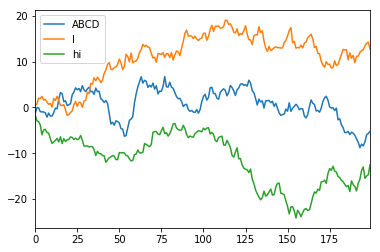

In [9]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(200, 3), columns=['ABCD', 'l', "hi"])

df = df.cumsum()

# df['Az'] = pd.Series(list(range(len(df))))
# df.plot(x='Az', y='B')

df.plot()

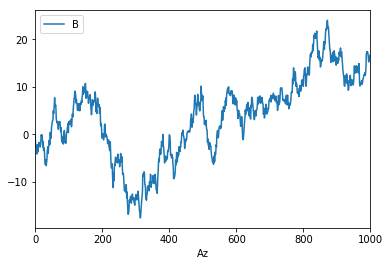

In [10]:
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['B', 'C']).cumsum()

df3['Az'] = pd.Series(list(range(len(df3))))
df3.plot(x='Az', y='B')

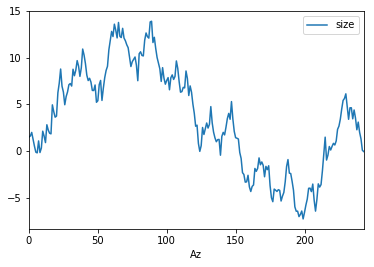

In [12]:
df3 = pd.DataFrame(np.random.randn(1000, 2), columns=['size', 'C']).cumsum()

df3['Az'] = pd.Series(list(range(len(data1_df))))
maze_types = ["original", "random maze", "room maze", "cellular automaton", "primitive", "row by row"]
df3.plot(x='Az', y='size')

In [15]:
import pandas as pd

maze_types = ["original", "random_maze", "room_maze", "cellular_automaton", "primitive", "row_by_row"]

def analize(stat, by="area"):
    df_all = pd.read_csv("Graph Stats1")
    data_dict = {}
    for i in range(len(maze_types)):
        df_all.filter(like=maze_types[i])
        isType =  df_all['type'] == maze_types[i]
        df = df_all[isType]
        display(df)
        data_dict[maze_types[i]] = df[stat]
        
    print(data_dict)
    
#     df.filter(like=mazeType)
#     isType =  df['type'] == mazeType
#     df = df[isType]
#     if by and title:
#         df.plot(x=by, title=title)
#     elif by:
#         df.plot(x=by, title=mazeType)
#     elif title:
#         df.plot(title=title)
#     else:
#         df.plot()


analize("pathLength")
dict1 = {
    'col1': ['A', 'A', 'B', 'l', 'D', 'C'],
    'col2': [2, 1, 9, 8, 7, 4],
    'col3': [0, 1, 9, 4, 2, 3],
}
x =  pd.DataFrame(dict1)
# display(x)
# pd.DataFrame({
#     'col1': ['A', 'A', 'B', np.nan, 'D', 'C'],
#     'col2': [2, 1, 9, 8, 7, 4],
#     'col3': [0, 1, 9, 4, 2, 3],
# })

,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength


,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength


,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength
0,room_maze,5by5,25,8,4,5,18,Null,Null,Null
1,room_maze,5by5,25,9,4,5,18,Null,Null,Null
2,room_maze,5by10,50,13,9,14,34,Null,Null,Null
3,room_maze,5by15,75,18,13,19,54,Null,Null,Null
4,room_maze,5by20,100,23,18,20,78,Null,Null,Null
5,room_maze,5by25,125,50,6,40,83,Null,Null,Null
6,room_maze,5by30,150,33,28,30,118,Null,Null,Null
7,room_maze,5by35,175,21,16,51,122,Null,Null,Null
8,room_maze,5by40,200,43,38,39,159,Null,Null,Null
9,room_maze,5by45,225,54,40,50,173,Null,Null,Null


,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength


,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength
82,primitive,6by4,24,8,4,8,14,Null,Null,Null
83,primitive,6by9,54,10,6,21,31,Null,Null,Null
84,primitive,6by14,84,19,12,33,49,Null,Null,Null
85,primitive,6by19,114,19,10,45,67,Null,Null,Null
86,primitive,6by24,144,26,14,58,84,Null,Null,Null
87,primitive,6by29,174,40,28,70,102,Null,Null,Null
88,primitive,6by34,204,38,26,83,119,Null,Null,Null
89,primitive,6by39,234,36,20,96,136,Null,Null,Null
90,primitive,6by44,264,41,30,108,154,Null,Null,Null
91,primitive,11by4,44,11,7,15,27,Null,Null,Null


,type,size,area,pathLength,distFromStartToFinish,walls,passages,time,score,playerPathLength
163,row_by_row,7by3,21,5,2,6,13,Null,Null,Null
164,row_by_row,7by8,56,10,6,18,36,Null,Null,Null
165,row_by_row,7by13,91,12,7,31,58,Null,Null,Null
166,row_by_row,7by18,126,21,14,38,86,Null,Null,Null
167,row_by_row,7by23,161,25,17,57,102,Null,Null,Null
168,row_by_row,7by28,196,30,22,60,134,Null,Null,Null
169,row_by_row,7by33,231,37,15,83,146,Null,Null,Null
170,row_by_row,7by38,266,31,22,102,162,Null,Null,Null
171,row_by_row,7by43,301,30,20,107,192,Null,Null,Null
172,row_by_row,12by3,36,3,1,15,19,Null,Null,Null


{'original': Series([], Name: pathLength, dtype: int64), 'random_maze': Series([], Name: pathLength, dtype: int64), 'room_maze': 0       8
1       9
2      13
3      18
4      23
5      50
6      33
7      21
8      43
9      54
10     13
11     20
12     28
13     36
14     43
15     33
16     39
17     76
18     51
19     17
20     41
21     33
22     36
23     38
24     62
25     55
26     53
27     52
28     22
29     34
     ... 
52    107
53    102
54     33
55     38
56     48
57     40
58     68
59     75
60    104
61    130
62     54
63    117
64     45
65     48
66     59
67     67
68    126
69     36
70    151
71     58
72     82
73     49
74     56
75     79
76    118
77    122
78    103
79     23
80    138
81    119
Name: pathLength, Length: 82, dtype: int64, 'cellular_automaton': Series([], Name: pathLength, dtype: int64), 'primitive': 82      8
83     10
84     19
85     19
86     26
87     40
88     38
89     36
90     41
91     11
92     19
93     20
94     32
95     3

{'primitive': 'black', 'row_by_row': 'pink', 'cellular_automaton': 'red', 'random_maze': 'orange', 'room_maze': 'green', 'original': 'purple'}


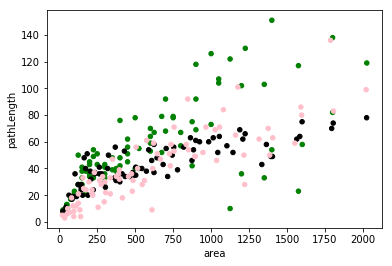

In [16]:
df = pd.read_csv("Graph Stats1")

colors = {'primitive': 'black', 'row_by_row': 'pink', 'cellular_automaton': 'red', 'random_maze': 'orange', 'room_maze': 'green', 'original': 'purple'}
print(colors)
df.plot.scatter(x='area', y='pathLength', c=[colors[r] for r in df['type']])

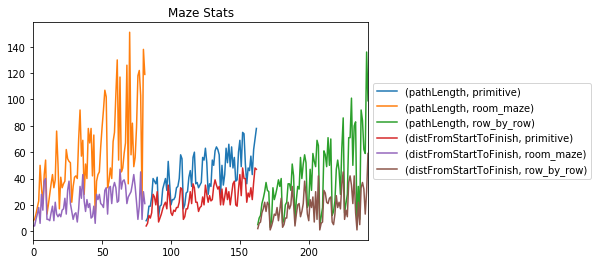

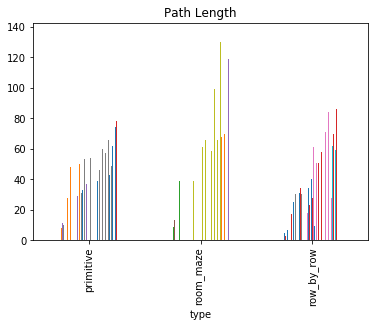

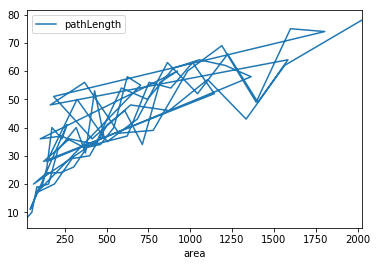

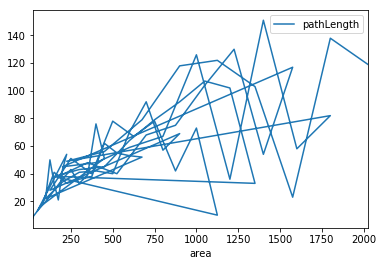

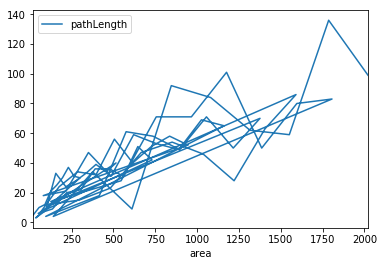

In [17]:
import matplotlib.pyplot as plt

def show_stats(df, values, title='Maze Stats'):
    f = plt.figure()
    plt.title(title, color='black')
    df.pivot(columns='type', values=values).plot(ax=f.gca())
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

    
df = pd.read_csv("Graph Stats1")
show_stats(df, ['pathLength', 'distFromStartToFinish'])
# show_stats(df, ['walls', 'passages'])

df.pivot_table(values='pathLength', index='type', columns=['area']).plot(kind='bar', legend=False, title='Path Length')


df = df.groupby(['type'])
df.plot(x="area", y='pathLength')
display(df)